In [1]:
import json
import gcsfs
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from dask.distributed import Client, LocalCluster
import dask
import zarr
from dask.diagnostics import ProgressBar
import cartopy.crs as ccrs

from utils import smooth_inputs, scale_separation
from cm26_utils import load_and_combine_cm26

from xhistogram.xarray import histogram


# set up gcs filesystem
# 👇 replace with your key 
with open( '/home/jovyan/KEYS/pangeo-forge-ocean-transport-4967-347e2048c5a1.json') as token_file:
    token = json.load(token_file)
fs = gcsfs.GCSFileSystem(token=token)
%config InlineBackend.figure_format='retina'

## What I am trying to calculate

$$C^* = \frac{Q^{actual}_{small}}{\overline{|\eta|^2}\Delta T}$$

I think this should actually be:

$$C^* = \frac{Q^{actual}_{small}}{\overline{|\eta|^2}|\Delta T|}$$ 

since we do not want to absorb the sign into c?

where

$$ \overline{|\eta|^2} = \overline{|U|^2} - |\overline{U}|^2 $$

In [2]:
import dask
from distributed import LocalCluster, Client

with dask.config.set({"distributed.scheduler.worker-saturation": "1.0"}):
    client = Client(LocalCluster())
client

# from dask_gateway import Gateway
# gateway = Gateway()

# # close existing clusters
# open_clusters = gateway.list_clusters()
# print(list(open_clusters))
# if len(open_clusters)>0:
#     for c in open_clusters:
#         cluster = gateway.connect(c.name)
#         cluster.shutdown()  

# options = gateway.cluster_options()

# options.worker_memory = 16 # 24 works fine for long term mean, but seasonal needs a bit more
# # options.worker_cores = 8

# options.environment = dict(
#     DASK_DISTRIBUTED__SCHEDULER__WORKER_SATURATION="1.0"
# )

# # Create a cluster with those options
# cluster = gateway.new_cluster(options)
# client = cluster.get_client()
# cluster.adapt(4, 100)
# client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/jbusecke/proxy/8787/status,
Dashboard: /user/jbusecke/proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 58.87 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43859,Workers: 4
Dashboard: /user/jbusecke/proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 58.87 GiB
Comm: tcp://127.0.0.1:33357,Total threads: 4
Dashboard: /user/jbusecke/proxy/35105/status,Memory: 14.72 GiB
Nanny: tcp://127.0.0.1:39867,


In [3]:
combined_mask = xr.open_dataset(fs.get_mapper('ocean-transport-group/scale-aware-air-sea/results/cm26_combined_map.zarr'), engine='zarr')

In [ ]:
ds = load_and_combine_cm26(fs, inline_array=True)

Load Data
Align in time
Interpolating ocean velocities
Regrid Atmospheric Data
Modify units
Mask nans
Calculate relative wind


In [ ]:
path = 'ocean-transport-group/scale-aware-air-sea/preprocessed/CM26_smoothed_split_v2.zarr'
mapper = fs.get_mapper(path)
ds_smoothed = xr.open_dataset(mapper, engine='zarr', chunks={}, consolidated=True)
filter_scale=ds_smoothed.surface_temp_smoothed.attrs['filter_scale']

In [ ]:
filter_scale=ds_smoothed.surface_temp_smoothed.attrs['filter_scale']

In [ ]:
# fs.ls('ocean-transport-group/scale-aware-air-sea/flux-output')

In [12]:
path = 'ocean-transport-group/scale-aware-air-sea/flux-output/cm26_split_full_v2.zarr'
mapper = fs.get_mapper(path)
ds_flux = xr.open_dataset(mapper, engine='zarr', chunks={}, consolidated=True)
# use just the 

In [13]:
def mag_sq(u,v):
    return u**2 + v**2

delta_t = ds.surface_temp - ds.t_ref
ds_mask = ds.isel(time=0)
landmask = np.logical_or(np.isnan(ds_mask.u_relative), np.isnan(ds_mask.v_relative))

value_mask = np.logical_and((mag_sq(ds.u_relative, ds.v_relative)**0.5)>5, np.abs(delta_t)>0.5)
u_sq_bar = smooth_inputs(mag_sq(ds.u_relative, ds.v_relative), (~landmask).astype(int), ['xt_ocean', 'yt_ocean'], filter_scale)
u_bar_sq = mag_sq(ds_smoothed.u_relative_smoothed, ds_smoothed.v_relative_smoothed)
eta_sq_bar = u_sq_bar - u_bar_sq


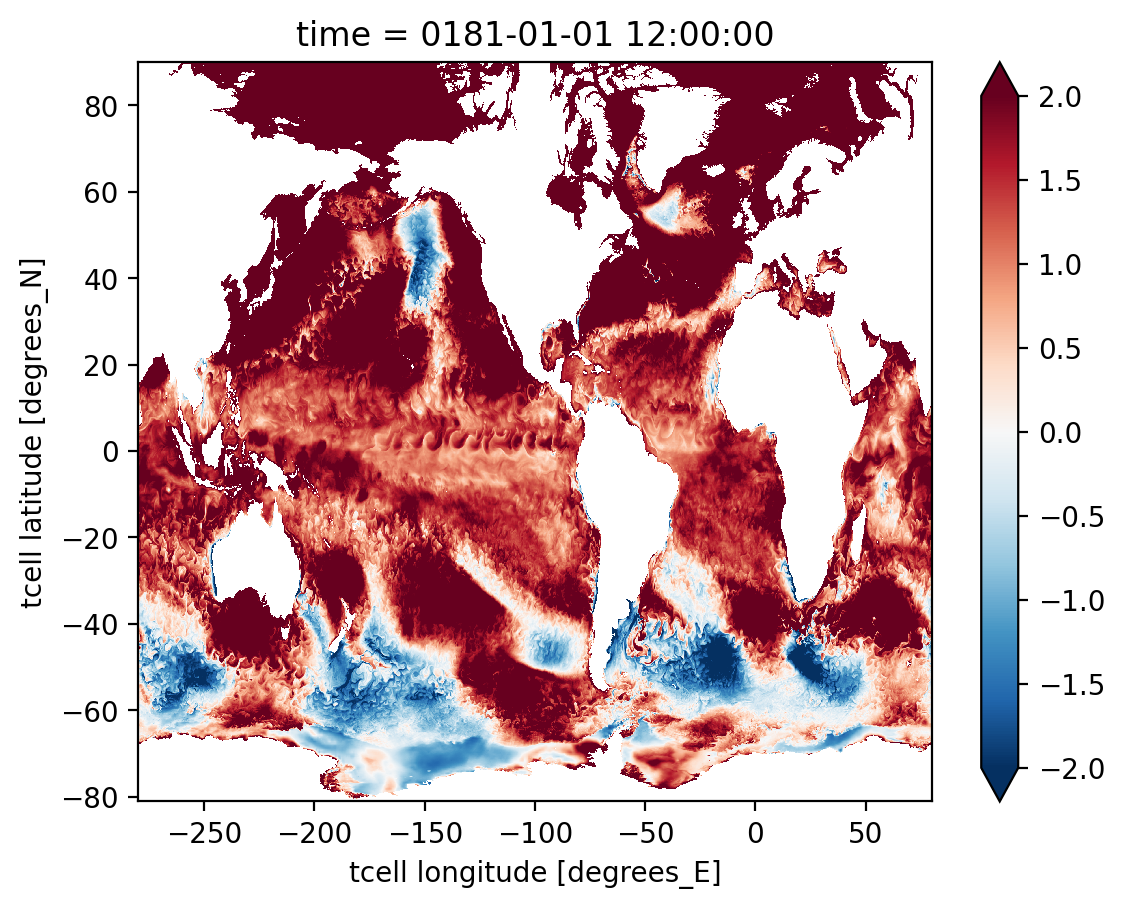

In [20]:
delta_t.isel(time=0).plot(vmax=2)

In [14]:
ds_full, ds_large_scale, ds_small_scale = scale_separation(ds_flux, filter_scale, ~landmask)
q_small = ds_small_scale['qh'].sel(algo='ecmwf', smoothing='smooth_all')

In [15]:
# so basically I am only taking 'significantly' large small scale contributions into account here. 
# Otherwise I get a lot of 0 values, which do not make a lot of sense in this context?
c_star = q_small/eta_sq_bar/delta_t # this is getting a bit gnarly
c_star = c_star

In [16]:
def subset(da):
    return da.isel(xt_ocean=slice(0,None,5), yt_ocean=slice(0,None,5))

In [18]:
ds_results = xr.Dataset({'q_small':q_small, 'delta_t':delta_t, 'eta_sq_bar':eta_sq_bar, 'c_star':c_star})
ds_results = ds_results.where(combined_mask['ice_land_mask'])
time_sample = slice(0,100, 10)
ds_results_sample = ds_results.isel(time=time_sample).load()
ds_results_sample

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
Exception ignored in: <bound method GCDiagnosis._gc_callback of <distributed.utils_perf.GCDiagnosis object at 0x7f3f22eb43d0>>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/utils_perf.py", line 179, in _gc_callback
    def _gc_callback(self, phase, info):
KeyboardInterrupt: 
2022-11-04 20:59:48,450 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-11-04 20:59:48,450 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-11-04 20:59:48,450 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):

In [ ]:
plt.figure()
subset(ds_results_sample['delta_t'].isel(time=0)).plot(vmax=5)

plt.figure()
subset(ds_results_sample['eta_sq_bar'].isel(time=0)).plot(vmax=5)

plt.figure()
subset(ds_results_sample['q_small'].isel(time=0)).plot(vmax=2)

In [52]:
test

<xarray.Dataset>
Dimensions:    (yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
    algo       <U8 'ecmwf'
    smoothing  <U13 'smooth_all'
    time       object 0181-01-01 12:00:00
  * xt_ocean   (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean   (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    geolat_t   (yt_ocean, xt_ocean) float32 ...
    geolon_t   (yt_ocean, xt_ocean) float32 ...
Data variables:
    evap       (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    qh         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ql         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    taux       (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    tauy       (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>

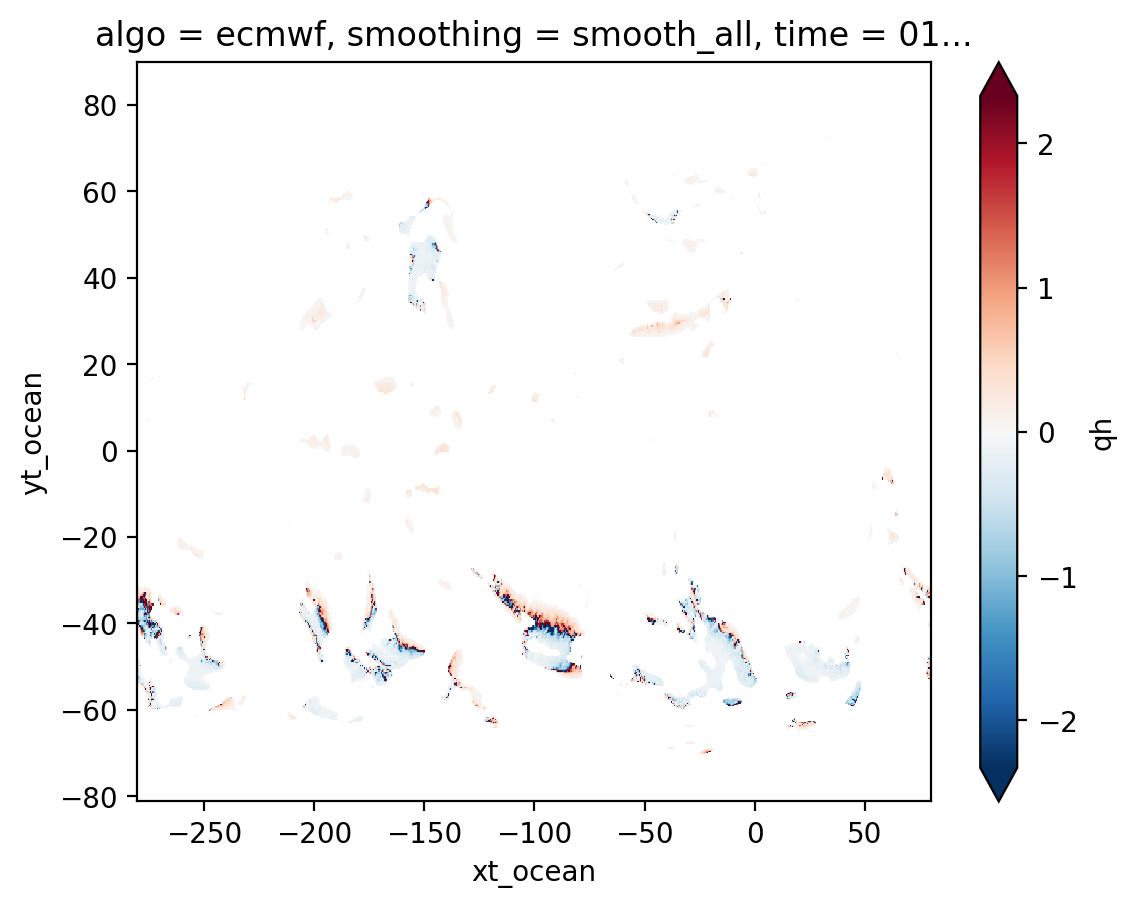

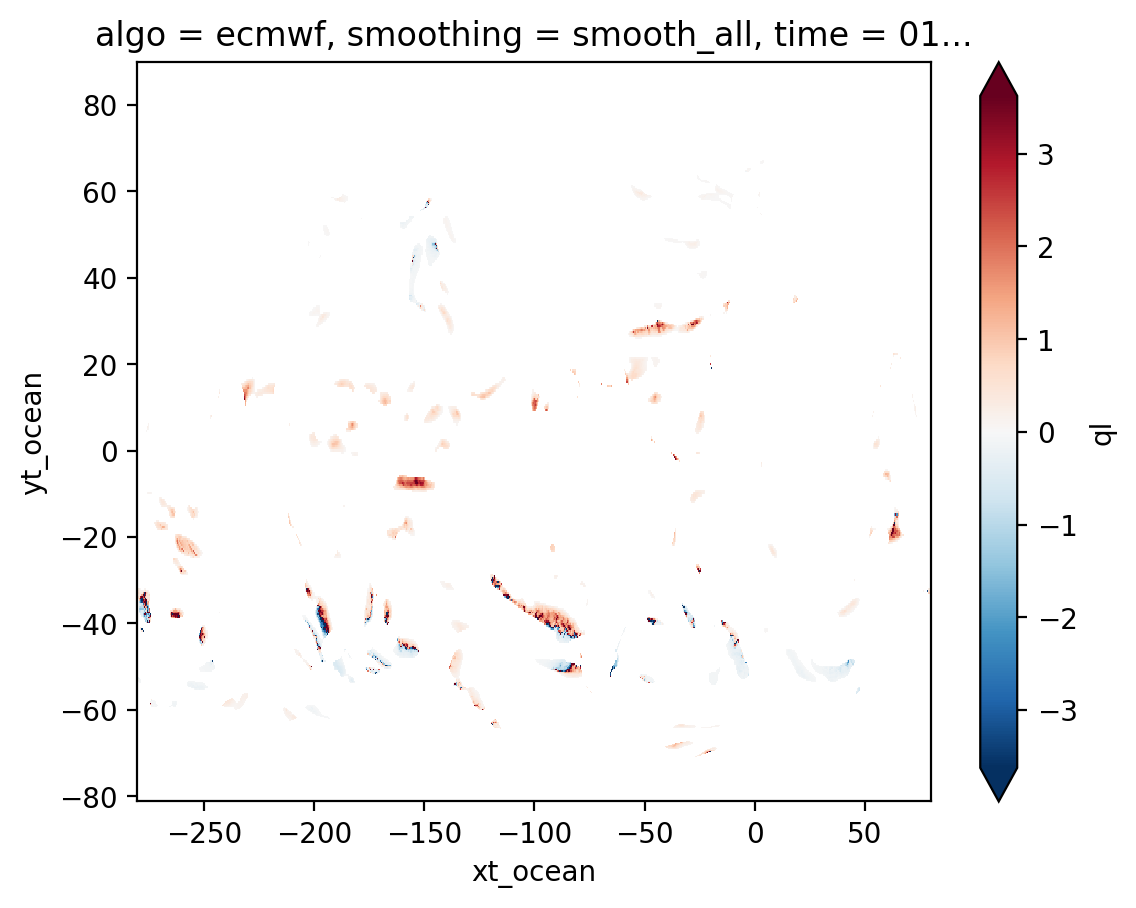

In [53]:
for var in ['qh','ql']:
    plt.figure()
    test[var].isel(xt_ocean=slice(0,None,5), yt_ocean=slice(0,None,5)).plot(robust=True)

In [55]:
from xhistogram.xarray import histogram
hist_c_star = histogram(c_star['ql'], bins=np.linspace(10, 10, 50), dim=['xt_ocean', 'yt_ocean'])

In [ ]:
# why does this take so long?


In [11]:
q_small['ql'].isel(time=0).plot()


KeyboardInterrupt



In [ ]:
delta_t.isel(time=0).plot(vmax=5)

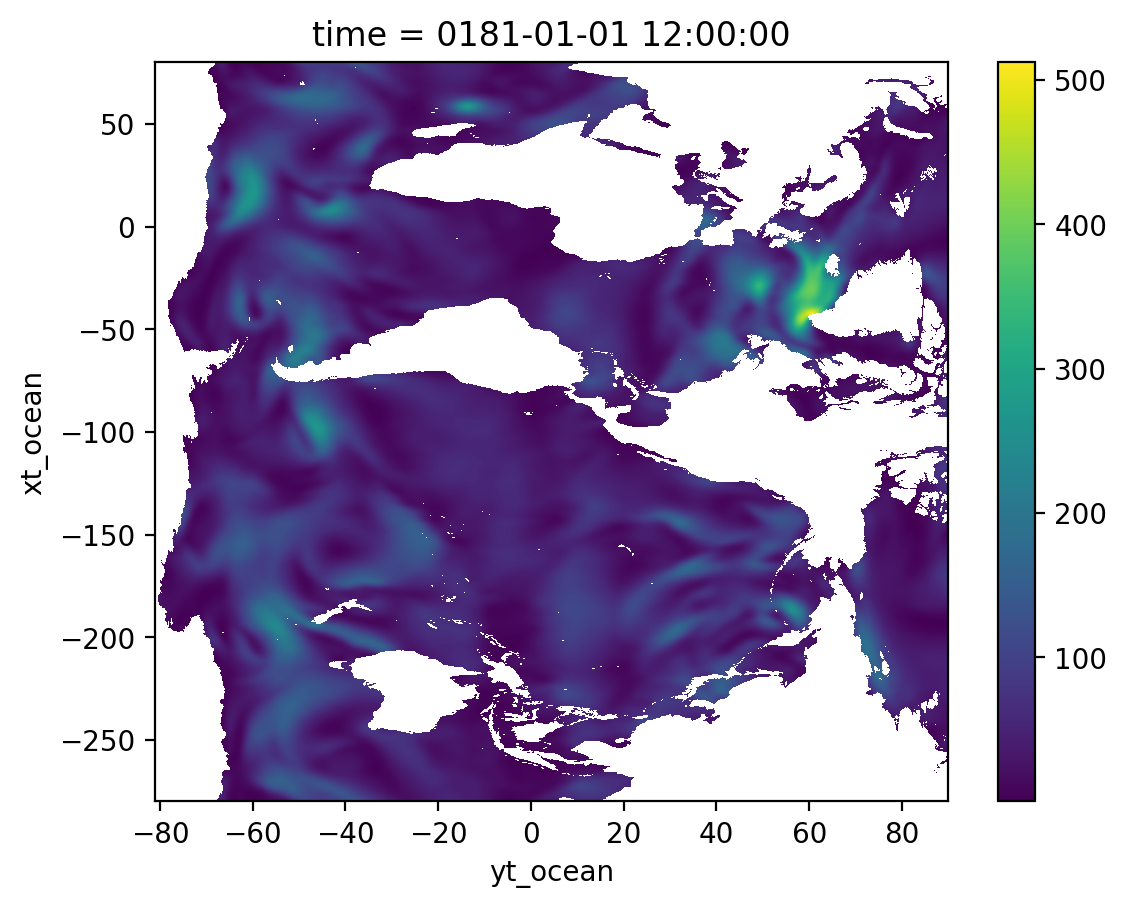

In [11]:
u_sq_bar.isel(time=0).plot(robust=True, x='xt_ocean')

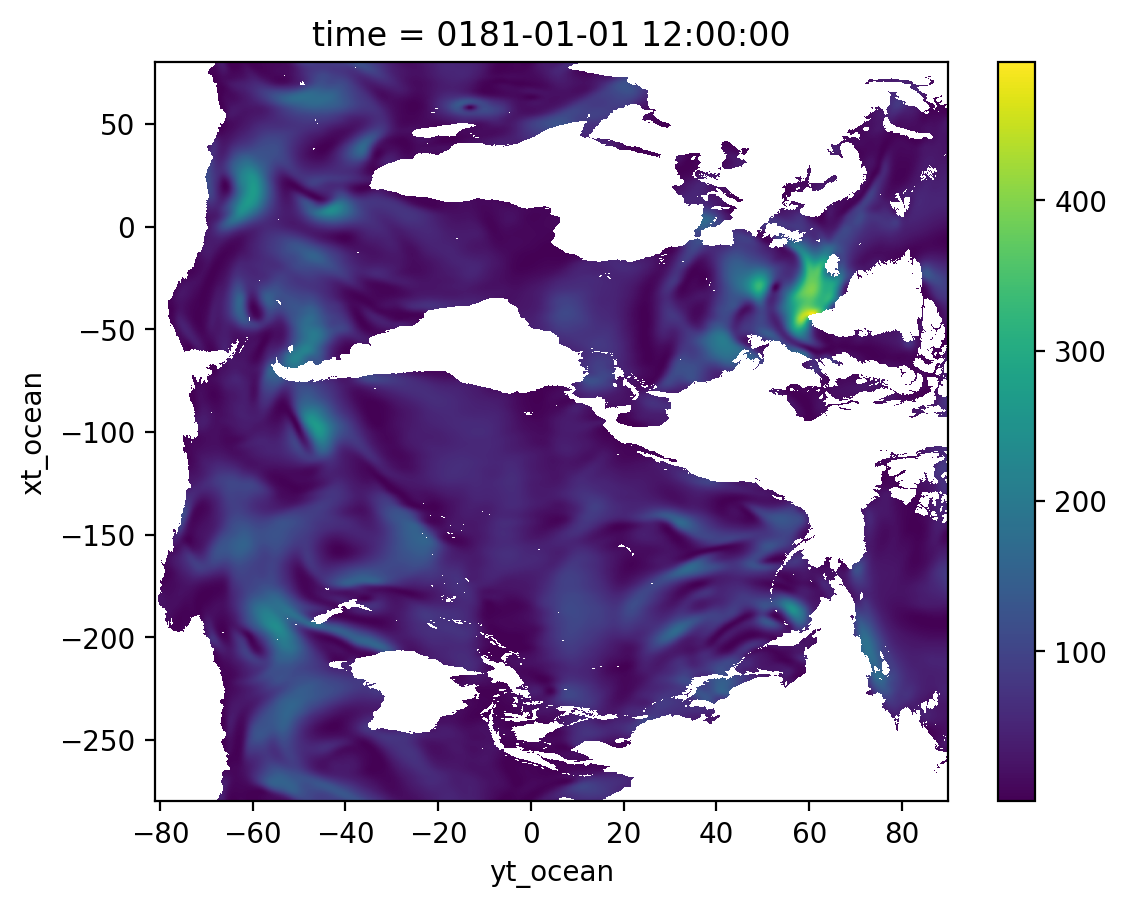

In [12]:
u_bar_sq.isel(time=0).plot(robust=True, x='xt_ocean')

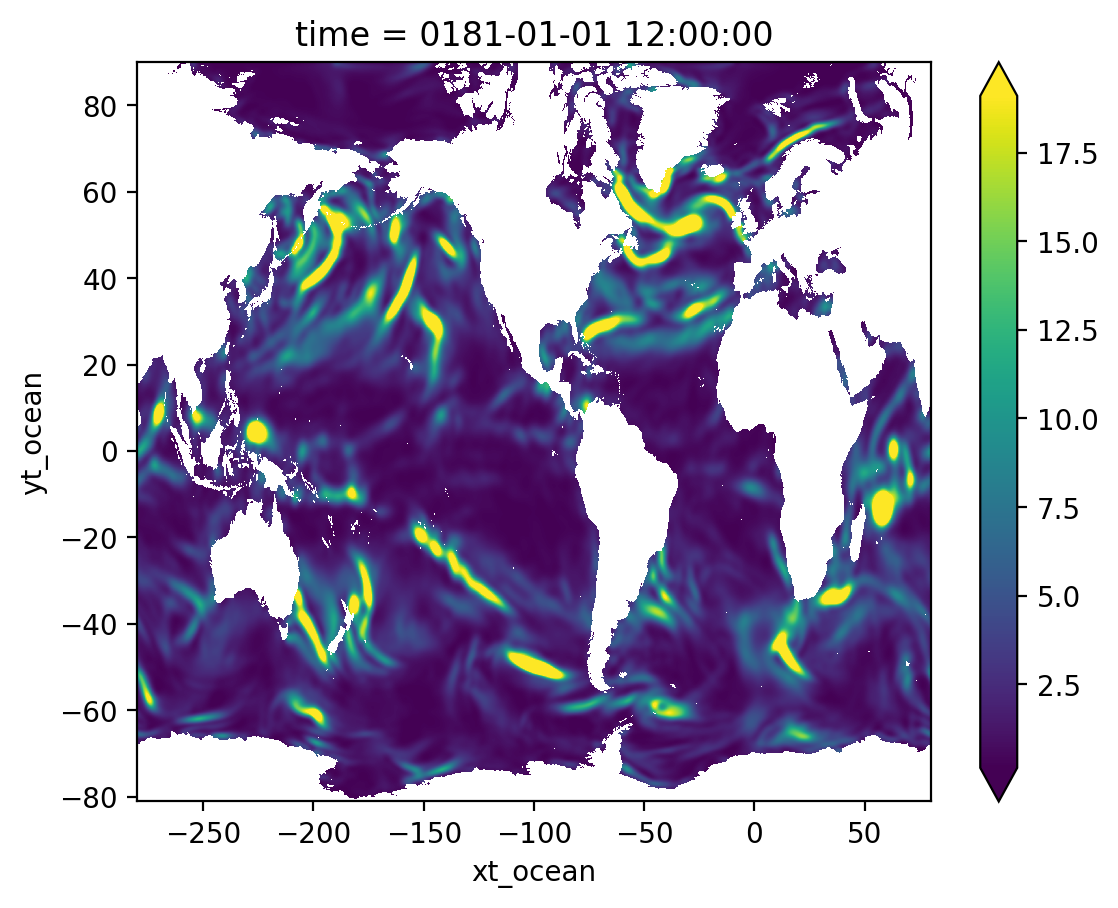

In [14]:
eta_sq_bar.isel(time=0).plot(robust=True, x='xt_ocean')

AssertionError: all arrays must have a name